# Group 14 - Project FP01
## Time series anomaly detection - DAGMM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
# transform in like collision
collisions['Timestamp'] = collisions_adjusted

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 119.49212002754211 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


In [7]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)

In [8]:
y_test_collision = df_with_labels["is_collision"]

## DAGMM


In [9]:
from algorithms.dagmm import DAGMM

classifier = DAGMM(
    num_epochs=100,
    lambda_energy=0.1,
    lambda_cov_diag=0.01,
    lr=5e-4,
    batch_size=128,
    gmm_k=3,
    normal_percentile=80,
    sequence_length=30,
    autoencoder_type=DAGMM.AutoEncoder.LSTM,  # Using LSTM autoencoder
    hidden_size=16,
    autoencoder_args={
        'n_layers': (1, 1),
        'use_bias': (True, True),
        'dropout': (0.1, 0.1)
    },
    seed=42,
    gpu=None,  # Set to None for CPU, or specify GPU index if available
    details=True
)

# Train the DAGMM on normal data
classifier.fit(X_train)
print("DAGMM training completed.")


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]

DAGMM training completed.


In [10]:
anomaly_scores = None
try:
    anomaly_scores = classifier.predict(X_test)
    # Replace inf values with the maximum float value
    anomaly_scores = np.nan_to_num(anomaly_scores, nan=np.nanmean(anomaly_scores), posinf=np.finfo(float).max, neginf=np.finfo(float).min)
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")
    # If an error occurs, you might want to inspect the model's internal state
print("Anomaly prediction completed.")

Anomaly prediction completed.


In [11]:
threshold_1 = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

In [12]:
median = np.median(anomaly_scores)
mad = np.median(np.abs(anomaly_scores - median))
threshold_2 = median + 3 * mad  

In [13]:
threshold_3 = np.percentile(anomaly_scores, 95)

In [14]:
Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)
IQR = Q3 - Q1
threshold_4 = Q3 + 1.5 * IQR

In [15]:
for threshold in [threshold_1, threshold_2, threshold_3, threshold_4]:
    anomalies_detected = sum(anomaly_scores >= threshold)
    print(f"Number of anomalies detected: {anomalies_detected} with threshold {threshold}")

Number of anomalies detected: 0 with threshold 27.85194388503006
Number of anomalies detected: 22 with threshold 26.669382390048767
Number of anomalies detected: 22 with threshold 27.04180539449056
Number of anomalies detected: 0 with threshold 29.560156110674143


### Anomaly Detection

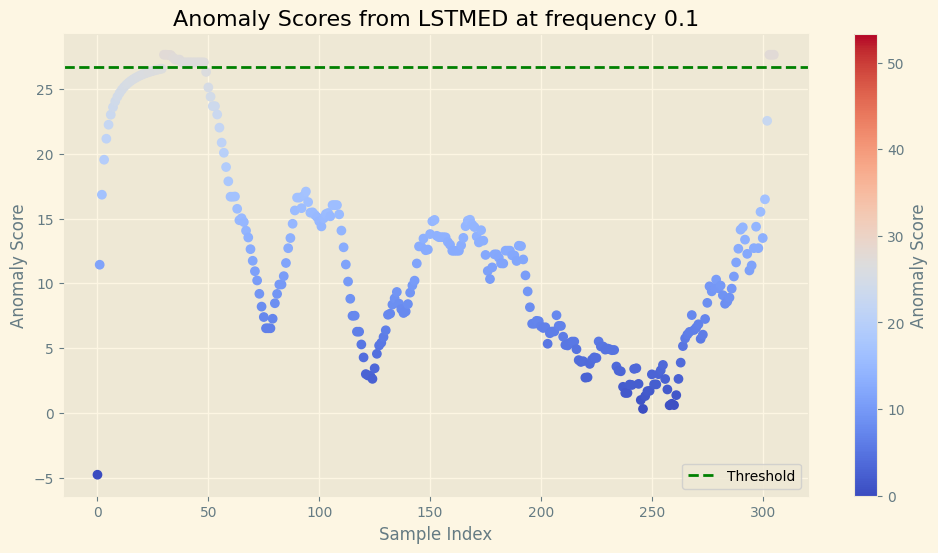

Number of anomalies detected: 22


In [16]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold_2)

In [17]:
np.count_nonzero(y_test_collision)

105

In [18]:
compute_metrics(anomaly_scores, y_test_collision, threshold_2)

ROC AUC Score: 0.5631
Detected anomaly class: 1
Threshold: 26.6694
F1 Score: 0.1575
Accuracy: 0.6503
Precision: 0.4545
Recall: 0.0952
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       201
           1       0.45      0.10      0.16       105

    accuracy                           0.65       306
   macro avg       0.56      0.52      0.47       306
weighted avg       0.59      0.65      0.57       306



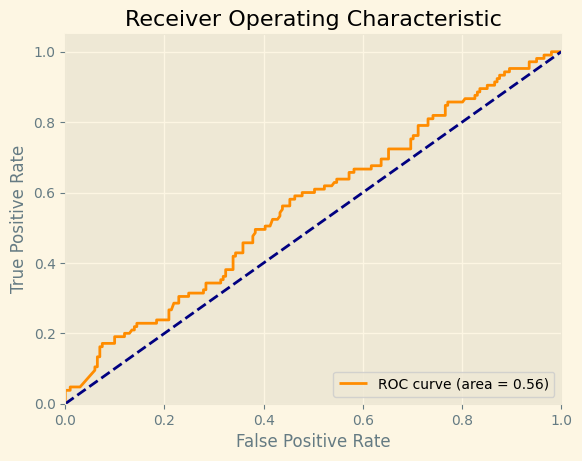

In [19]:
plot_roc_curve(y_test_collision.values, anomaly_scores)

## Map anomalies to original time series

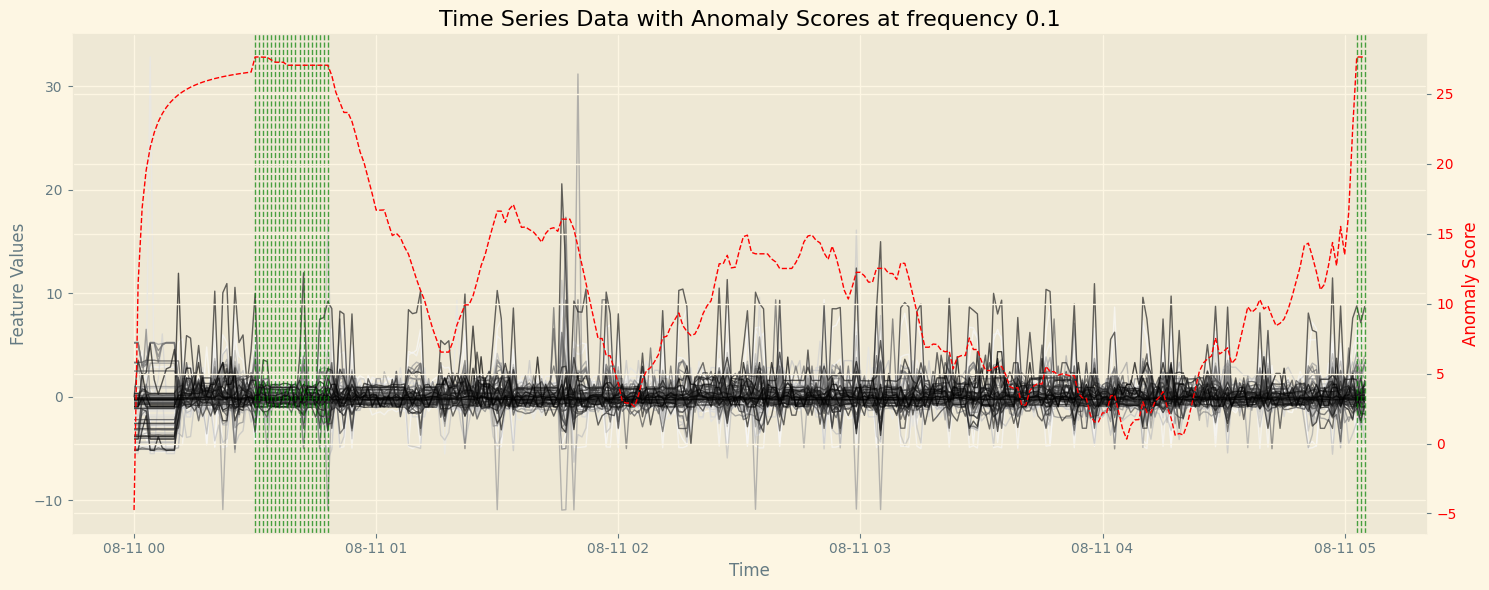

Top 22 Anomalies:
              timestamp  anomaly_score  \
303 2022-08-11 05:03:00      27.631021   
304 2022-08-11 05:04:00      27.631021   
305 2022-08-11 05:05:00      27.631021   
30  2022-08-11 00:30:00      27.631018   
31  2022-08-11 00:31:00      27.630993   
32  2022-08-11 00:32:00      27.615505   
33  2022-08-11 00:33:00      27.607552   
34  2022-08-11 00:34:00      27.419769   
35  2022-08-11 00:35:00      27.257500   
36  2022-08-11 00:36:00      27.254606   
37  2022-08-11 00:37:00      27.254569   
38  2022-08-11 00:38:00      27.041805   
39  2022-08-11 00:39:00      27.041805   
40  2022-08-11 00:40:00      27.041805   
41  2022-08-11 00:41:00      27.041805   
42  2022-08-11 00:42:00      27.041805   
43  2022-08-11 00:43:00      27.041805   
44  2022-08-11 00:44:00      27.041805   
45  2022-08-11 00:45:00      27.041805   
46  2022-08-11 00:46:00      27.041805   
47  2022-08-11 00:47:00      27.041805   
48  2022-08-11 00:48:00      27.041805   

     machine_na

In [20]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)